## Plot composites GEV ##

Plot the composites of temperature and wind speed for the worst demand net wind days.

In [1]:
# Imports
import os
import sys
import glob
import time
import re

# Third-party libraries
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.coords
import cftime
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs

# Specific third-party imports
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from scipy.stats import pearsonr
from iris.util import equalise_attributes

# Import types
from typing import Any, Callable, Union, List, Tuple

# Local imports
from plotting_functions import format_func, format_func_one_decimal

# Non-local imports
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import plot_dps_composite, plot_daily_field

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# ---------------------------------
# Load the dataframe containing the dates for the ERA5 period
# ---------------------------------

# Set up the path to the obs dnw dataframe
obs_dnw_path = "/home/users/benhutch/unseen_multi_year/dfs/UK_obs_demand_net_wind_max_djf_1960-2017_2025-03-18.csv"

# Load the obs dnw dataframe
obs_dnw_df = pd.read_csv(obs_dnw_path)

In [3]:
%%time
# ---------------------------------
# Load in the ERA5 daily temperature data
# ---------------------------------

# set up the data path to the temp data
temp_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_t2m_daily_1950_2020.nc"

# Load the data
temp_cube = iris.load_cube(temp_path, "t2m")

CPU times: user 36.7 ms, sys: 14.9 ms, total: 51.6 ms
Wall time: 885 ms


In [4]:
%%time
# ---------------------------------
# Load in the ERA5 daily 10m wind speed data
# ---------------------------------

# Set up the base path
base_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/"

# Set up the path to the wind data
obs_path = os.path.join(base_path, "ERA5_wind_daily_1952_2020.nc")

# Load the data
wind_cube = iris.load_cube(obs_path, "si10")

CPU times: user 4.82 ms, sys: 4.97 ms, total: 9.79 ms
Wall time: 11.6 ms


In [5]:
%%time
# ---------------------------------
# Load in the ERA5 data for mean sea level pressure
# ---------------------------------

# # Set up the path to the data
data_path = (
    "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_msl_daily_1960_2020_daymean.nc"
)

# # Load the data
psl_cube = iris.load_cube(data_path, "msl")

CPU times: user 73.4 ms, sys: 94.3 ms, total: 168 ms
Wall time: 171 ms


In [6]:
# ---------------------------------
# Restrict both obs datasets to a specific Europe box
# ---------------------------------

# Define the box to constrain to
test_europe_box = {
    "lon1": -11,  # degrees east
    "lon2": 30,
    "lat1": 35,  # degrees north
    "lat2": 70,
}

# Define the constraints
constraints = iris.Constraint(
    longitude=lambda cell: test_europe_box["lon1"] <= cell <= test_europe_box["lon2"],
    latitude=lambda cell: test_europe_box["lat1"] <= cell <= test_europe_box["lat2"],
)

# Apply the constraints
temp_cube_eu = temp_cube.extract(constraints)
wind_cube_eu = wind_cube.extract(constraints)
psl_cube_eu = psl_cube.extract(constraints)

In [7]:
temp_cube_eu

<iris 'Cube' of 2 metre temperature / (K) (time: 25933; latitude: 124; longitude: 146)>

In [8]:
# ---------------------------------
# Restrict the obs data to specific dates
# ---------------------------------

# Define the start and end dates
start_date = "1960-12-01"
end_date = "2017-03-01"

# Convert the dates to datetime objects
start_date_dt = pd.to_datetime(start_date)
end_date_dt = pd.to_datetime(end_date)

# Create a time constraint
time_constraint = iris.Constraint(time=lambda cell: start_date_dt <= cell.point < end_date_dt)

# Apply the date constraints
temp_cube_eu = temp_cube_eu.extract(time_constraint)

# Same for the wind data
wind_cube_eu = wind_cube_eu.extract(time_constraint)

# Same for the pressure data
psl_cube_eu = psl_cube_eu.extract(time_constraint)

# Subset the cubes to months 12, 1, 2
temp_cube_eu = temp_cube_eu.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

# Same for the wind data
wind_cube_eu = wind_cube_eu.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

# Same for the pressure data
psl_cube_eu = psl_cube_eu.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

In [9]:
# ---------------------------------
# Calculate the climatology for the observed datasets
# ---------------------------------

# Calculate the climatology for temp data
temp_climatology = temp_cube_eu.collapsed("time", iris.analysis.MEAN)

# Calculate the climatology for wind data
wind_climatology = wind_cube_eu.collapsed("time", iris.analysis.MEAN)

# Calculate the climatology for pressure data
psl_climatology = psl_cube_eu.collapsed("time", iris.analysis.MEAN)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


In [10]:
# Extract the dates from the obs dnw dataframe
dates = pd.to_datetime(obs_dnw_df["time"]).values

In [11]:
dates

array(['1960-12-13T00:00:00.000000000', '1961-12-18T00:00:00.000000000',
       '1963-02-22T00:00:00.000000000', '1964-02-20T00:00:00.000000000',
       '1964-12-18T00:00:00.000000000', '1966-01-17T00:00:00.000000000',
       '1966-12-14T00:00:00.000000000', '1968-02-20T00:00:00.000000000',
       '1969-02-17T00:00:00.000000000', '1970-02-11T00:00:00.000000000',
       '1971-01-03T00:00:00.000000000', '1972-01-05T00:00:00.000000000',
       '1973-02-26T00:00:00.000000000', '1973-12-24T00:00:00.000000000',
       '1975-02-10T00:00:00.000000000', '1976-02-18T00:00:00.000000000',
       '1977-01-12T00:00:00.000000000', '1978-02-15T00:00:00.000000000',
       '1979-01-27T00:00:00.000000000', '1980-02-26T00:00:00.000000000',
       '1981-02-15T00:00:00.000000000', '1981-12-25T00:00:00.000000000',
       '1983-02-13T00:00:00.000000000', '1984-02-14T00:00:00.000000000',
       '1985-01-19T00:00:00.000000000', '1986-02-20T00:00:00.000000000',
       '1987-01-31T00:00:00.000000000', '1987-12-08

In [12]:
# ---------------------------------
# Make sure the dates are in the correct datetime format
# ---------------------------------

# Convert the dates to datetime objects
dates = pd.to_datetime(dates)

In [14]:
# ---------------------------------
# Format the dates as cftime objects
# ---------------------------------

# Convert the dates to cftime objects
dates_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates]

# Extract the time points from the temp cube
time_points_temp = temp_cube_eu.coord("time").points

# Extract the time points from the wind cube
time_points_wind = wind_cube_eu.coord("time").points

# Extract the time points from the psl cube
time_points_psl = psl_cube_eu.coord("time").points

# Extract the time units from the temp cube
time_units_temp = temp_cube_eu.coord("time").units
calendar_temp = temp_cube_eu.coord("time").units.calendar

# Same for the wind data
time_units_wind = wind_cube_eu.coord("time").units
calendar_wind = wind_cube_eu.coord("time").units.calendar

# same for the psl data
time_points_psl = psl_cube_eu.coord("time").points
time_units_psl = psl_cube_eu.coord("time").units.calendar

# Convert the dates to cftime objects
dates_temp_cf = cftime.num2date(
    time_points_temp, units=time_units_temp.origin, calendar=calendar_temp
)

# Same for wind
dates_wind_cf = cftime.num2date(
    time_points_wind, units=time_units_wind.origin, calendar=calendar_wind
)

# same for psl
dates_psl_cf = cftime.num2date(
    time_points_psl, units="hours since 1900-01-01", calendar=calendar_wind
)

# Convert to cftime datetime objects
dates_temp_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates_temp_cf]

# Same for wind
dates_wind_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates_wind_cf]

# same for psl
dates_psl_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates_psl_cf]

In [15]:
# ---------------------------------
# Extract the correct dates to create the composites
# ---------------------------------

# Set up an empty cubelist for temperature
temp_composite_list = iris.cube.CubeList()

# Set up an empty cubelist for wind
wind_composite_list = iris.cube.CubeList()

# Set up an empty cubelist for pressure
psl_composite_list = iris.cube.CubeList()

# Loop over the dates
for date in tqdm(dates_cf[:-1]):
    # Find the index where this date exists
    index_temp = np.where(np.array(dates_temp_cf) == date)[0][0]
    index_wind = np.where(np.array(dates_wind_cf) == date)[0][0]
    index_psl = np.where(np.array(dates_psl_cf) == date)[0][0]

    # Extract the cube at this index
    temp_cube_date = temp_cube_eu[index_temp]
    wind_cube_date = wind_cube_eu[index_wind]
    psl_cube_date = psl_cube_eu[index_psl]

    # Append to the cubelist
    temp_composite_list.append(temp_cube_date)
    wind_composite_list.append(wind_cube_date)
    psl_composite_list.append(psl_cube_date)

# Merge the cubes
temp_composite = temp_composite_list.merge_cube()
wind_composite = wind_composite_list.merge_cube()
psl_composite = psl_composite_list.merge_cube()

100%|██████████| 57/57 [00:00<00:00, 75.82it/s]


In [16]:
# ---------------------------------
# Calculate the anomalies
# ---------------------------------

# Calculate the anomalies for temperature
temp_anomalies = temp_composite.collapsed("time", iris.analysis.MEAN) - temp_climatology

# Calculate the anomalies for wind
wind_anomalies = wind_composite.collapsed("time", iris.analysis.MEAN) - wind_climatology

# Calculate the anomalies for pressure
psl_anomalies = psl_composite.collapsed("time", iris.analysis.MEAN) - psl_climatology

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


In [17]:
%%time
# ---------------------------------
# Extract the values
# ---------------------------------

# Extract the values for temperature
temp_anoms_arr = temp_anomalies.data

# Extract the values for wind
wind_anoms_arr = wind_anomalies.data

CPU times: user 2.01 s, sys: 34 s, total: 36.1 s
Wall time: 7min 2s


In [18]:
%%time
# ---------------------------------
# Extract the PSL data
# ---------------------------------

# Extract the values for pressure
psl_anoms_arr = psl_anomalies.data

CPU times: user 1.47 s, sys: 10.3 s, total: 11.8 s
Wall time: 9.97 s


In [19]:
np.min(psl_anoms_arr)

np.float32(-555.7969)

In [21]:
np.max(psl_anoms_arr)

np.float32(1286.1328)

In [22]:
# ---------------------------------
# Set up a mask for the europe land mass
# ---------------------------------

import cartopy.io.shapereader as shpreader

# Set up the LONS and LATS
LONS, LATS = iris.analysis.cartography.get_xy_grids(temp_anomalies)

# Flatten the lats and lons
x, y = LONS.flatten(), LATS.flatten()

# Set up the countries shapefile
countries_shp = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)

In [23]:
%%time
# ---------------------------------
# Set up the land shapefile
# ---------------------------------

# Set up the land shapefile
MASK_MATRIX_TMP = np.zeros([len(x), 1])
country_shapely = []
for country_record in shpreader.Reader(countries_shp).records():
        country_shapely.append(country_record.geometry)

CPU times: user 812 ms, sys: 6.58 ms, total: 818 ms
Wall time: 839 ms


In [24]:
country_shapely

[<MULTIPOLYGON (((117.704 4.163, 117.704 4.163, 117.738 4.157, 117.784 4.157,...>,
 <MULTIPOLYGON (((117.704 4.163, 117.697 4.169, 117.644 4.215, 117.64 4.227, ...>,
 <MULTIPOLYGON (((-69.51 -17.507, -69.506 -17.585, -69.497 -17.621, -69.476 -...>,
 <POLYGON ((-69.51 -17.507, -69.51 -17.505, -69.508 -17.434, -69.511 -17.399,...>,
 <MULTIPOLYGON (((-69.51 -17.507, -69.638 -17.626, -69.684 -17.656, -69.729 -...>,
 <MULTIPOLYGON (((-67.194 -22.822, -67.143 -22.743, -67.113 -22.71, -67.038 -...>,
 <POLYGON ((33.781 34.976, 33.76 34.98, 33.717 34.978, 33.702 34.973, 33.703 ...>,
 <MULTIPOLYGON (((33.782 34.976, 33.781 34.976, 33.78 34.979, 33.776 34.98, 3...>,
 <MULTIPOLYGON (((77.8 35.495, 77.815 35.473, 77.834 35.452, 77.857 35.437, 7...>,
 <MULTIPOLYGON (((78.918 33.386, 78.916 33.388, 78.824 33.461, 78.801 33.494,...>,
 <POLYGON ((34.248 31.211, 34.264 31.224, 34.316 31.257, 34.351 31.289, 34.35...>,
 <MULTIPOLYGON (((34.481 31.583, 34.52 31.558, 34.556 31.54, 34.528 31.52, 34...>,
 <PO

In [25]:
# ---------------------------------
# Create a mask for the land
# ---------------------------------
import shapely.geometry

# Loop over the x points
# Create a mask for the country
for i in range(0, len(x)):
    point = shapely.geometry.Point(x[i], y[i])
    for country in country_shapely:
        if country.contains(point) == True:
            MASK_MATRIX_TMP[i, 0] = 1.0

MASK_MATRIX_RESHAPE = np.reshape(MASK_MATRIX_TMP, (np.shape(LONS)))

In [26]:
# print the number of 1s in the mask
np.sum(MASK_MATRIX_RESHAPE)

np.float64(9512.0)

In [27]:
# ---------------------------------
# Apply the mask to the temperature and wind data
# ---------------------------------

# Apply the mask to the temperature data
temp_anoms_arr_masked = np.ma.masked_where(MASK_MATRIX_RESHAPE == 0, temp_anoms_arr)

In [41]:
np.min(wind_anoms_arr)

np.float32(-5.5433774)

In [43]:
np.max(wind_anoms_arr)

np.float32(1.5392466)

In [39]:
# ---------------------------------
# Set up the clevs for temperature and wind speed
# ---------------------------------

# Set up the clevs for temperature
temp_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

# Set up the clevs for wind speed
wind_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

# Set up the clevs for pressure
psl_levels = np.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [29]:
# ---------------------------------
# Set up the number of days
# ---------------------------------

# Set up the number of days for obs
num_days = len(dates)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'tranform'
  result = super().contourf(*args, **kwargs)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'tranform'
  result = super().contourf(*args, **kwargs)


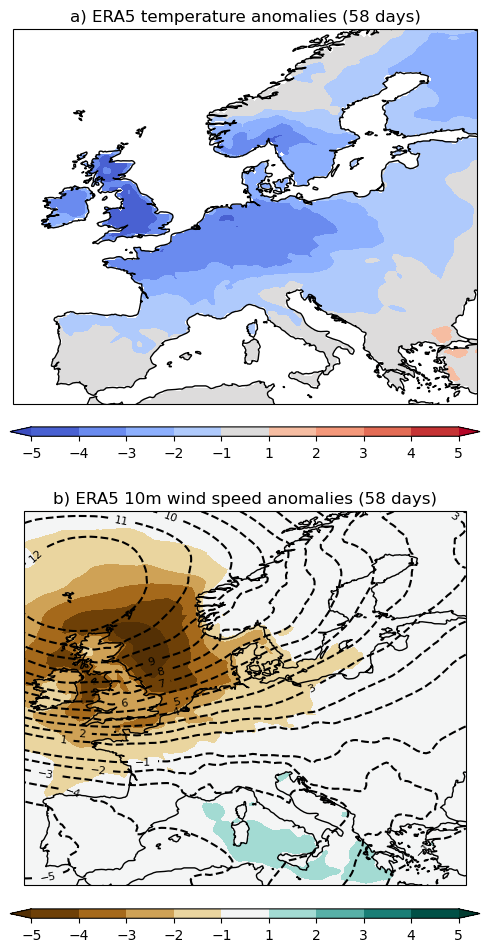

In [40]:
# ---------------------------------
# Plot the figure
# ---------------------------------

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up a figure with 2 rows and 1 column
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the temperature anomalies
ax1 = axs[0]

# Set u the map
mymap1 = ax1.contourf(
    temp_anomalies.coord("longitude").points,
    temp_anomalies.coord("latitude").points,
    temp_anoms_arr_masked,
    cmap="coolwarm",
    tranform=ccrs.PlateCarree(),
    levels=temp_clevs,
    extend="both",
)

ax1.coastlines()

# Set up the title
ax1.set_title(f"a) ERA5 temperature anomalies ({num_days} days)")

# Include a cbar to the side
cbar1 = plt.colorbar(mymap1, ax=ax1, orientation="horizontal", pad=0.05, aspect=50)

# # Create a divider for the existing axes instance
# divider = make_axes_locatable(ax1)

# # Append axes to the right of ax1, with 5% width of ax1
# cax = divider.append_axes("right", size="5%", pad=0.05)

# # Create the colorbar in the new axes
# cbar1 = plt.colorbar(mymap1, cax=cax)

# # plot only the land data
# ax1.add_feature(cartopy.feature.LAND, edgecolor="black")

# Plot the wind anomalies
ax2 = axs[1]

# Set u the map
mymap2 = ax2.contourf(
    wind_anomalies.coord("longitude").points,
    wind_anomalies.coord("latitude").points,
    wind_anoms_arr,
    cmap="BrBG",
    tranform=ccrs.PlateCarree(),
    levels=wind_clevs,
    extend="both",
)

# Superimpose the psl anomaly contours
psl_contour = ax2.contour(
    psl_anomalies.coord("longitude").points,
    psl_anomalies.coord("latitude").points,
    psl_anoms_arr / 100,
    levels=psl_levels,
    colors="black",
    linestyles="dashed",
    transform=ccrs.PlateCarree(),
)

# set labels for the contours
ax2.clabel(psl_contour, inline=True, fontsize=8)

ax2.coastlines()

# Include a cbar to the side
cbar2 = plt.colorbar(mymap2, ax=ax2, orientation="horizontal", pad=0.05, aspect=50)

# Set up the title
ax2.set_title(f"b) ERA5 10m wind speed anomalies ({num_days} days)")

# Set up a tight layout
plt.tight_layout()